In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def GetBatchIndex(num_data, mini_batch_size):
    # Get the index per batch
    batch_index = []
    for m in range(num_data // mini_batch_size + 1):
        batch_index.append(m*mini_batch_size)
    if num_data % mini_batch_size != 0: # For dataset not divisible by batch size
        batch_index.append(num_data)
    return batch_index

In [3]:
def RandomBatches(X, y, num_data):
    # Randomize the order of data and label
    permute = np.random.permutation(num_data) # Random index
    return X[:, permute], y[:, permute]

In [4]:
def Initialization(layers_neurons):
    # Initialize weights to random number and previous iteration Delta to zero (used in momentum term)
    weights = []
    bias = []
    prev_Delta_w = []
    prev_Delta_b = []
    layers = len(layers_neurons)
    for l in range(1, layers): # The first layer is input layer
        # w = np.random.randn(layers_neurons[l], layers_neurons[l-1]) * 0.01
        w = np.random.uniform(
            2.4/layers_neurons[l-1], -2.4/layers_neurons[l-1], # +-2.4 divided by Fan-in or number of input
            size=(layers_neurons[l], layers_neurons[l-1]))
        b = np.zeros((layers_neurons[l],1))
        weights.append(w)
        bias.append(b)
        prev_Delta_w.append(np.zeros_like(w))
        prev_Delta_b.append(np.zeros_like(b))
    return weights, bias, prev_Delta_w, prev_Delta_b

In [5]:
def ActivationFunction(x, activation):
    # Activation formula used in forward propaation
    if activation == 'Logistic':
        f = 1/(1 + np.exp(-x))
        return f
    if activation == 'ReLU':
        f = np.maximum(0, x)
        return f

In [6]:
def ForwardCompute(weights, bias, input, activations):
    # Forward Propagation
    x = input # Output of current layer
    activity = [x] # Values to be used later in backprop & weight update
    for A, b, activation in zip(weights, bias, activations):
        h = A @ x + b
        x = ActivationFunction(h, activation)
        activity.append(h)
        activity.append(x)
    return activity # activity = list(input, h1, x1,...,hn, xn)

In [7]:
def ErrorCompute(y_predicted, y_batch):
    # Compute the sum of squares error
    N = y_batch.shape[1] # Number of examples
    log_cost = np.multiply(-np.log(y_predicted), y_batch) + np.multiply(-np.log(1 - y_predicted), 1 - y_batch)
    cost = 1/N * np.sum(log_cost)
    Dcost = 1/N * (y_batch - y_predicted) # Derivative cost * Derivative logistic (simplified)
    return cost, Dcost

In [8]:
def DActivation(h, x, activation):
    # Derivative of activation function to be used in Backpropagation
    if activation == 'Logistic':
        D_phi = x * (1 - x)
        return D_phi
    if activation == 'ReLU':
        D_phi = np.where(h>0, 1, 0) # Derivative is 1 if greater than 0 and 0 otherwise
        return D_phi

In [9]:
def Backpropagation(weights, activations, activity, Dcost):
    # Backpropagation to calculate the delta or local gradient
    delta = []
    delta.append(Dcost)
    q = Dcost # Local gradient of the last layer
    # Dcost * DActivation(activity[-2], activity[-1][1:], activations[-1]) <-- if not classification
    for j in reversed(range(1, len(weights))): # Backprop starts with the last layer
        # Hidden Neuron: delta_hidden = activation_derivative * A.T @ q
        delta_h = DActivation(activity[2*(j)-1], activity[2*(j)], activations[j-1]) * (weights[j].T @ q)
        delta = [delta_h] + delta # Append delta to the front of the list
        q = delta_h # delta[l+1]
    return delta

In [10]:
def WeightUpdate(delta, weights, bias, prev_Delta_w, prev_Delta_b, activity, learning_rate, beta):
    # Updates the weight and optimize with momentum term
    for j in reversed(range(len(weights))):
        # Delta_w = learning_rate * q @ x.T + momentum_rate * prev_Delta
        Delta_w = learning_rate * delta[j] @ activity[2*(j)].T + beta * prev_Delta_w[j]
        Delta_b = learning_rate * np.sum(delta[j], axis=1, keepdims=True) + beta * prev_Delta_b[j]
        prev_Delta_w[j] = Delta_w
        prev_Delta_b[j] = Delta_b
        weights[j] += Delta_w
        bias[j] += Delta_b
    return weights, bias, prev_Delta_w, prev_Delta_b

In [11]:
def Predict(weights, bias, X, activations):
    # Make predictions based on the trained weights
    y_predict = ForwardCompute(weights, bias, X, activations)[-1]
    predictions = np.argmax(y_predict, axis=0) # Index of maximum value in the output neuron
    return predictions, y_predict # predictions is in integer form

In [12]:
def MLP(X, y, X_v, y_v, layers_neurons, activations, mini_batch_size=8, learning_rate=0.001, beta=0.1, epoch=200):
    error_train = np.zeros(epoch+1) # Errors of the training set every epoch
    error_v = np.zeros(epoch+1) # Errors of the validation set every epoch
    num_data = X.shape[1] # Number of training examples
    batch_index = GetBatchIndex(num_data, mini_batch_size)
    batches = len(batch_index) # Number of mini batches
    weights, bias, prev_Delta_w, prev_Delta_b = Initialization(layers_neurons)
    for i in range(epoch+1):
        X_random, y_random = RandomBatches(X, y, num_data)
        batch_cost = 0 # Cumulative cost of batches
        for index in range(1, batches):
            # Randomize the training data and labels based on permuted index
            X_batch = X_random[:, batch_index[index-1]:batch_index[index]]
            y_batch = y_random[:, batch_index[index-1]:batch_index[index]]
            activity = ForwardCompute(weights, bias, X_batch, activations)
            y_predict_train = activity[-1]
            cost, Dcost = ErrorCompute(y_predict_train, y_batch)
            batch_cost += cost
            delta = Backpropagation(weights, activations, activity, Dcost)
            weights, bias, prev_Delta_w, prev_Delta_b  = WeightUpdate(delta, weights, bias, prev_Delta_w, prev_Delta_b, activity, learning_rate, beta)
        cost_avg = batch_cost/(batches-1) # Average batch cost per epoch
        error_train[i] = cost_avg
        _, y_predict_v = Predict(weights, bias, X_v, activations)
        error_v[i], _ = ErrorCompute(y_predict_v, y_v)
    return error_train, error_v, weights, bias

In [13]:
def GraphError(epoch, error_train, error_validation):
    e1 = np.arange(0, epoch+1)
    plt.figure()
    plt.plot(e1, error_train, label='Training')
    plt.plot(e1, error_validation, label='Validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title('Metrics')
    return

In [14]:
def GraphConfusionMatrix(weights, bias, X_test, y_test, activations):
    num_class = y_test.shape[0]
    predictions, _ = Predict(weights, bias, X_test, activations)
    true_labels = np.argmax(y_test, axis=0)

    # Compute the confusion matrix
    confusion_matrix = np.zeros((num_class, num_class), dtype=int)
    for true_label, pred_label in zip(true_labels, predictions):
        confusion_matrix[true_label, pred_label] += 1
        
    # Plot the confusion matrix
    plt.figure(figsize=(num_class, num_class))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Add labels to the plot
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(0, num_class))
    plt.yticks(tick_marks, range(0, num_class))

    # Add values to the confusion matrix cells
    thresh = confusion_matrix.max() / 2
    for i in range(num_class):
        for j in range(num_class):
            plt.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
    return confusion_matrix

In [15]:
def ComputeMetrics(confusion_matrix):
    # Number of classes
    num_classes = confusion_matrix.shape[0]

    # Initialize arrays
    TP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    FN = np.zeros(num_classes)

    # Iterate over each class
    for i in range(num_classes):
        # True positives: diagonal element of the class
        TP[i] = confusion_matrix[i, i]
        # True negatives: sum of all elements except the row and column of the class
        TN[i] = np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :]) - np.sum(confusion_matrix[:, i]) + TP[i]
        # False positives: sum of the column excluding the diagonal element
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        # False negatives: sum of the row excluding the diagonal element
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    metrics = np.array([accuracy.mean(), precision.mean(), recall.mean(), f1_score.mean()])
    metrics_class = np.hstack([np.vstack([accuracy, precision, recall, f1_score]), metrics.reshape(-1,1)])
    print('accuracy:', metrics[0], '\nprecision:', metrics[1], '\nrecall:', metrics[2], '\nf1_score:', metrics[3])
    return metrics_class

In [16]:
def OneHot(data):
    # One-hot encoding
    one_hot = np.eye(data.max()+1)[:,data]
    return one_hot

In [17]:
def TrainTestSplit(X, y):
    num_samples = y.shape[1]
    permute = np.random.permutation(num_samples)
    # permute the data and label arrays
    X_permute = X[:,permute] # shuffle the columns of x according to perm
    y_permute = y[:,permute] # shuffle the elements of y according to perm
    # get the indices to split at
    validation_idx = int(0.6 * num_samples) # 60% of the length
    test_idx = int(0.8 * num_samples) # 80% of the length
    # split the data and label arrays
    X_train, X_validation, X_test  = np.split(X_permute, [validation_idx, test_idx], axis=1) # split along the first axis (rows)
    y_train, y_validation, y_test = np.split(y_permute, [validation_idx, test_idx], axis=1) # split along the first axis (rows)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [266]:
X = np.loadtxt('data', delimiter=',').T
y = OneHot(np.loadtxt('labels').astype(int))
X_train, X_validation, X_test, y_train, y_validation, y_test = TrainTestSplit(X, y)

In [267]:
layers_neurons = [X.shape[0], 256, 128, 64, 32, y.shape[0]]
activations = ['ReLU', 'ReLU', 'ReLU', 'ReLU', 'Logistic']
mini_batch_size = 64
learning_rate = 0.0009
beta = 0.9
epoch = 40

In [268]:
error_train, error_validation, weights, bias = MLP(
    X_train, y_train, X_validation, y_validation,
    layers_neurons, activations, mini_batch_size=mini_batch_size,
    learning_rate=learning_rate, beta=beta, epoch=epoch)

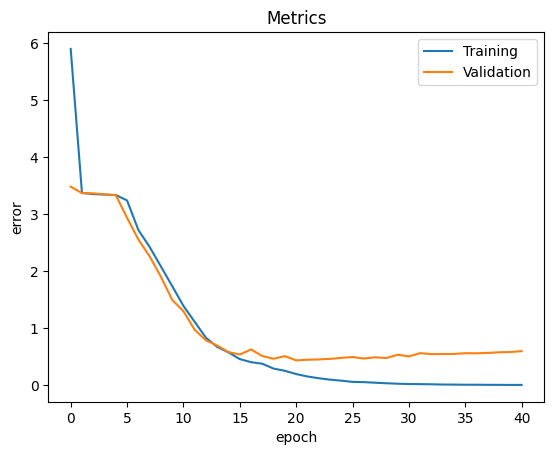

In [269]:
GraphError(epoch, error_train, error_validation)

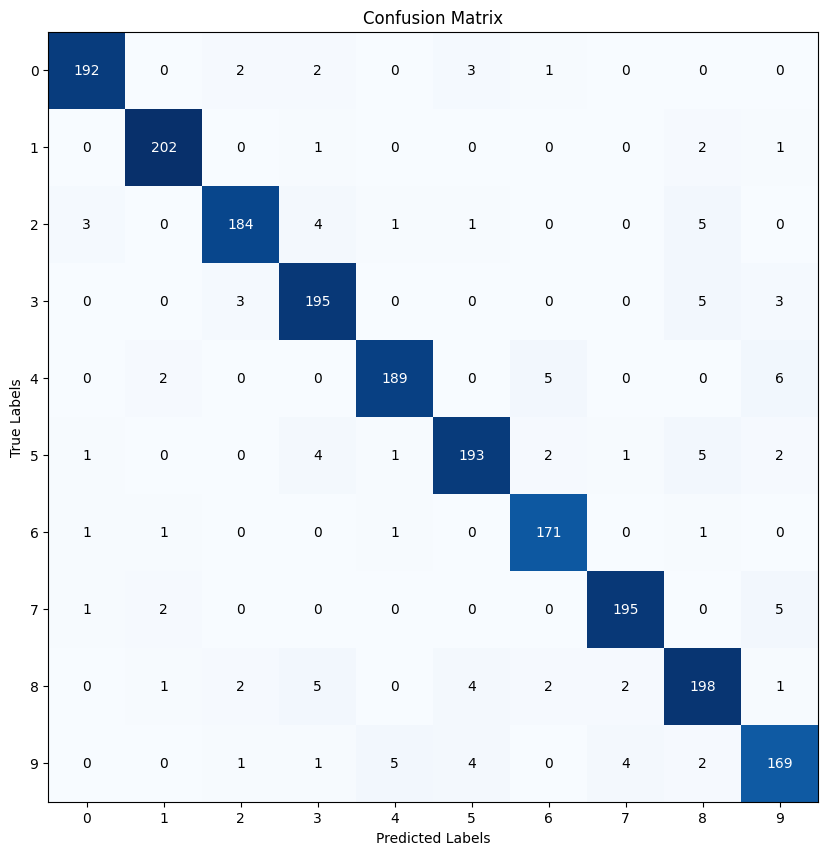

In [270]:
confusion_matrix = GraphConfusionMatrix(weights, bias, X_test, y_test, activations)

In [271]:
Metrics = ComputeMetrics(confusion_matrix)

accuracy: 0.9888 
precision: 0.9441947859628076 
recall: 0.9442832308988894 
f1_score: 0.9441362193384


In [273]:
Metrics

array([[0.993     , 0.995     , 0.989     , 0.986     , 0.9895    ,
        0.986     , 0.993     , 0.9925    , 0.9815    , 0.9825    ,
        0.9888    ],
       [0.96969697, 0.97115385, 0.95833333, 0.91981132, 0.95939086,
        0.94146341, 0.94475138, 0.96534653, 0.90825688, 0.90374332,
        0.94419479],
       [0.96      , 0.98058252, 0.92929293, 0.94660194, 0.93564356,
        0.92344498, 0.97714286, 0.96059113, 0.92093023, 0.90860215,
        0.94428323],
       [0.96482412, 0.97584541, 0.94358974, 0.93301435, 0.94736842,
        0.93236715, 0.96067416, 0.96296296, 0.91454965, 0.90616622,
        0.94413622]])

In [276]:
np.savetxt('Metrics.csv', Metrics, delimiter=',', fmt='%.3f')